# Walkthrough: Scoring a trained CNTK model with PySpark on a Microsoft Azure HDInsight cluster

by Miruna Oprescu, Sudarshan Raghunathan, and Mary Wahl, 2017

This notebook demonstrates how a trained [Microsoft Cognitive Toolkit](https://github.com/Microsoft/CNTK/wiki) deep learning model can be applied to files in an [Azure Blob Storage Account](https://azure.microsoft.com/en-us/services/storage/blobs/) in a distributed and scalable fashion using the [Spark Python API](http://spark.apache.org/docs/2.1.0/programming-guide.html) (PySpark) on a Microsoft Azure HDInsight cluster. An image classification model pretrained on the [CIFAR-10](https://www.cs.toronto.edu/~kriz/cifar.html) dataset is applied to 10,000 withheld images. A sample of the images is shown below along with their classes:

<img src="https://cntk.ai/jup/201/cifar-10.png" width=500 height=500>

To begin, follow the instructions below to set up a cluster and storage account. You will be prompted to upload a copy of this notebook to the cluster, where you can continue following the walkthrough by executing the PySpark code cells.

### Outline
- [Load sample images into a Spark Resiliant Distributed Dataset or RDD](#images)
   - [Load modules and define presets](#imports)
   - [Download the dataset locally on the Spark cluster](#tarball)
   - [Convert the dataset into an RDD](#rdd)   
- [Score the images using a trained CNTK model](#score)
   - [Download the trained CNTK model to the Spark cluster](#model)
   - [Define functions to be used by worker nodes](#functions)
   - [Score the images on worker nodes](#map)
   - [Evaluate model accuracy](#evaluate)

<a name="images"></a>
## Load sample images into a Spark Resiliant Distributed Dataset or RDD

We will now use Python to obtain the [CIFAR-10](https://www.cs.toronto.edu/~kriz/cifar.html) image set compiled and distributed by Alex Krizhevsky, Vinod Nair, and Geoffrey Hinton. For more details on the dataset, see Alex Krizhevsky's [Learning Multiple Layers of Features from Tiny Images](https://www.cs.toronto.edu/~kriz/learning-features-2009-TR.pdf) (2009).

<a name="imports"></a>
### Load modules and define presets

Execute the cell below by selecting it with the mouse or arrow keys, then pressing Shift+Enter.

In [1]:
from cntk import load_model
import os
import numpy as np
import pandas as pd
import pickle
import sys
from pyspark import SparkFiles
import tarfile
from urllib.request import urlretrieve
import xml.etree.ElementTree

cifar_uri = 'http://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz' # Location of test image dataset
mean_image_uri = 'https://raw.githubusercontent.com/Azure-Samples/hdinsight-pyspark-cntk-integration/master/CIFAR-10_mean.xml' # Mean image for subtraction
model_uri = 'https://github.com/Azure-Samples/hdinsight-pyspark-cntk-integration/raw/master/resnet20_meanimage_159.dnn' # Location of trained model
local_tmp_dir = '/tmp/cifar'
local_cifar_path = os.path.join(local_tmp_dir, os.path.basename(cifar_uri))
local_model_path = os.path.join(local_tmp_dir, 'model.dnn')
local_mean_image_path = os.path.join(local_tmp_dir, 'mean_image.xml')
os.makedirs(local_tmp_dir, exist_ok=True)

<a name="tarball"></a>
### Download the dataset locally on the Spark cluster

The image data are `ndarray`s stored in a Python `dict` which has been pickled and tarballed. The cell below downloads the tarball and extracts the `dict` containing the test image data.

In [2]:
if not os.path.exists(local_cifar_path):
    urlretrieve(cifar_uri, filename=local_cifar_path)

with tarfile.open(local_cifar_path, 'r:gz') as f:
    test_dict = pickle.load(f.extractfile('cifar-10-batches-py/test_batch'), encoding='latin1')

<a name="rdd"></a>
### Convert the dataset into an RDD

The following code cell illustrates how the collection of images can be distributed to create a Spark RDD. The cell creates an RDD with one partition per worker to limit the number of times that the trained model must be reloaded during scoring.

In [3]:
def reshape_image(record):
    image, label, filename = record
    return image.reshape(3,32,32).transpose(1,2,0), label, filename

image_rdd = sc.parallelize(zip(test_dict['data'], test_dict['labels'], test_dict['filenames']))
image_rdd = image_rdd.map(reshape_image)

To convince ourselves that the data has been properly loaded, let's visualize a few of these images. For plotting, we will need to transfer them to the local context by way of a Spark dataframe:

In [4]:
sample_images = image_rdd.take(5)
image_data = np.array([i[0].reshape((32*32*3)) for i in sample_images]).T
image_labels = [i[2] for i in sample_images]
image_df = pd.DataFrame(image_data, columns=image_labels)
spark.createDataFrame(image_df).coalesce(1).write.mode("overwrite").csv("/tmp/cifar_image", header=True) 

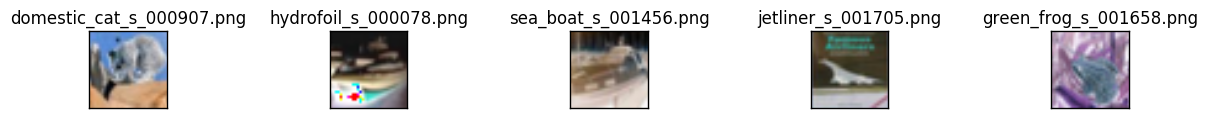

In [5]:
%%local
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from glob import glob

!rm -rf /tmp/cifar_image
!hdfs dfs -copyToLocal /tmp/cifar_image /tmp/cifar_image
image_df = pd.read_csv(glob('/tmp/cifar_image/*.csv')[0])
plt.figure(figsize=(15,1))
for i, col in enumerate(image_df.columns):
    plt.subplot(1, 5, i+1)
    image = image_df[col].values.reshape((32, 32, 3))
    plt.imshow(image)
    plt.title(col)
    cur_axes = plt.gca()
    cur_axes.axes.get_xaxis().set_visible(False)
    cur_axes.axes.get_yaxis().set_visible(False)

<a name="score"></a>
## Score the images using a trained CNTK model

Now that the cluster and sample dataset have been created, we can use PySpark to apply a trained model to the images.

<a name="model"></a>
### Download the trained CNTK model and mean image to the Spark cluster

We previously trained a twenty-layer ResNet model to classify CIFAR-10 images by following [this tutorial](https://github.com/Microsoft/CNTK/tree/master/Examples/Image/Classification/ResNet) from the CNTK git repo. The model expects input images to be preprocessed by subtracting the mean image defined in an OpenCV XML file. The following cell downloads both the trained model and the mean image, and ensures that data from both files can be accessed by worker nodes.

In [6]:
urlretrieve(model_uri, local_model_path)
sc.addFile(local_model_path)

urlretrieve(mean_image_uri, local_mean_image_path)
mean_image = xml.etree.ElementTree.parse(local_mean_image_path).getroot()
mean_image = [float(i) for i in mean_image.find('MeanImg').find('data').text.strip().split(' ')]
mean_image = np.array(mean_image).reshape((32, 32, 3)).transpose((2, 0, 1))
mean_image_bc = sc.broadcast(mean_image)

<a name="functions"></a>
### Define functions to be used by worker nodes

The following functions will be used during scoring to load, preprocess, and score images. A class label (integer in the range 0-9) will be returned for each image, along with its filename.

In [7]:
def get_preprocessed_image(my_image, mean_image):
    ''' Reshape and flip RGB order '''
    my_image = my_image.astype(np.float32)
    bgr_image = my_image[:, :, ::-1] # RGB -> BGR
    image_data = np.ascontiguousarray(np.transpose(bgr_image, (2, 0, 1)))
    image_data -= mean_image
    return(image_data)

def run_worker(records):
    ''' Scoring script run by each worker '''
    loaded_model = load_model(SparkFiles.get('./model.dnn'))
    mean_image = mean_image_bc.value

    # Iterate through the records in the RDD.
    # record[0] is the image data
    # record[1] is the true label
    # record[2] is the file name
    for record in records:
        preprocessed_image = get_preprocessed_image(record[0], mean_image)
        dnn_output = loaded_model.eval({loaded_model.arguments[0]: [preprocessed_image]})
        yield record[1], np.argmax(np.squeeze(dnn_output))

<a name="map"></a>
### Score the images on worker nodes

The code cell below maps each partition of `image_rdd` to a worker node and collects the results. Runtimes of 1-3 minutes are typical.

In [8]:
labelled_images = image_rdd.mapPartitions(run_worker)

# Time how long it takes to score 10k test images
start = pd.datetime.now()
results = labelled_images.collect()
print('Scored {} images'.format(len(results)))
stop = pd.datetime.now()
print(stop - start)

Scored 10000 images
0:01:37.840075

<a name="evaluate"></a>
### Evaluate model accuracy

The trained model assigns a class label (represented by an integer value 0-9) to each image. We now compare the true and predicted class labels to evaluate our model's accuracy.

In [9]:
df = pd.DataFrame(results, columns=['true_label', 'predicted_label'])

num_correct = sum(df['true_label'] == df['predicted_label'])
num_total = len(results)
print('Correctly predicted {} of {} images ({:0.2f}%)'.format(num_correct, num_total, 100 * num_correct / num_total))

Correctly predicted 9165 of 10000 images (91.65%)

We can construct a confusion matrix to visualize which classification errors are most common:

In [10]:
spark.createDataFrame(df).coalesce(1).write.mode("overwrite").csv("/tmp/cifar_scores", header=True) 

Constructing a confusion matrix with the first 10000 samples


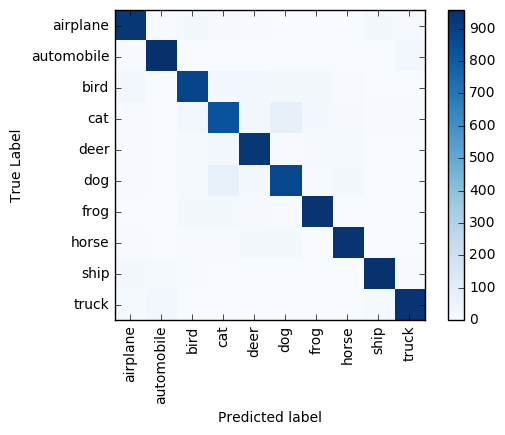

In [12]:
%%local
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import os
from glob import glob

!rm -rf /tmp/cifar_scores
!hdfs dfs -copyToLocal /tmp/cifar_scores /tmp/cifar_scores
df = pd.read_csv(glob('/tmp/cifar_scores/*.csv')[0])
print('Constructing a confusion matrix with the first {} samples'.format(len(df.index)))

label_to_name_dict = {0: 'airplane',
                      1: 'automobile',
                      2: 'bird',
                      3: 'cat',
                      4: 'deer',
                      5: 'dog',
                      6: 'frog',
                      7: 'horse',
                      8: 'ship',
                      9: 'truck'}

labels = np.sort(df['true_label'].unique())
named_labels = [label_to_name_dict[i] for i in labels]
cm = confusion_matrix(df['true_label'], df['predicted_label'], labels=labels)

plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.colorbar()
tick_marks = np.arange(len(labels))
plt.xticks(tick_marks, named_labels, rotation=90)
plt.yticks(tick_marks, named_labels)
plt.xlabel('Predicted label')
plt.ylabel('True Label')
plt.show()

The matrix shows that the most common errors include:
- mislabeling cats as dogs, and vice versa
- mislabeling birds as airplanes, and vice versa
- confusing "automobiles" with "trucks", and vice versa